#Deep Learning con Python
`Autor: Erwing FC 
~erwingforerocastro@gmail.com`

###Preparando los datos

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
result_prefix = "paris_generated"

# Pesos de los diferentes componentes de la pérdida
total_variation_weight = 1e-6 #para la perdida de variación
style_weight = 1e-6           #para la perdida de estilo
content_weight = 2.5e-8       #para la perdida de contenido

# Dimensiones de la imagen generada.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400 
img_ncols = int(width * img_nrows / height)
print(img_ncols)

599


In [ ]:
#las imagenes
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

###Funciones de preprocesamiento / deprocesamiento de imágenes

In [5]:
def preprocess_image(image_path):
    # Función de utilidad para abrir, cambiar el tamaño y formatear imágenes en los tensores adecuados
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Función util para convertir un tensor en una imagen válida
    x = x.reshape((img_nrows, img_ncols, 3))
    # Eliminar el centro-cero por píxel medio
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

###Calculo de la pérdida de transferencia de estilo

`gram_matrix` (usado para calcular la pérdida de estilo)

La `style_loss` función, que mantiene la imagen generada cerca de las texturas locales de la imagen de referencia de estilo.

La `content_loss` función, que mantiene la representación de alto nivel de la imagen generada cerca de la de la imagen base.

La `total_variation_loss` función, una pérdida de regularización que mantiene la imagen generada localmente coherente

In [6]:
# La matriz de gram de un tensor de imagen (producto externo de características)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# La "pérdida de estilo" está diseñada para mantener
# el estilo de la imagen de referencia en la imagen generada.
# Se basa en las matrices gram (que capturan el estilo) de
# mapas de características de la imagen de referencia de estilo
# y de la imagen generada


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# Una función de pérdida auxiliar
# diseñado para mantener el "contenido" del
# imagen base en la imagen generada


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# La tercera función de pérdida, pérdida de variación total,
# diseñado para mantener la imagen generada localmente coherente


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

######Extraemos las capas necesarias del modelo

In [7]:
# Modelo VGG19 cargado con pesos de ImageNet entrenados previamente
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Salidas simbólicas de cada capa "clave" (nombres únicos).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Devuelve los valores de activación para cada capa en
# VGG19 (como un dictado).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80142336/80134624 [==============================] - 3s 0us/step


######Finalmente, codigo que calcula la perdida de transferencia de estilo

In [8]:
# Lista de capas que se utilizarán para la pérdida de estilo.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# La capa que se utilizará para la pérdida de contenido.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Inicializa la perdida
    loss = tf.zeros(shape=())

    # Agregar pérdida de contenido
    layer_features = features[content_layer_name] #sacamos las caracteristicas en la capa block5_conv2
    base_image_features = layer_features[0, :, :, :] #las caracteristicas de la imagen base
    combination_features = layer_features[2, :, :, :] #las caracteristicas de la imagen a generar
    loss = loss + content_weight * content_loss(      #y le sumamos a perdida el peso_cont*perdida_contenido
        base_image_features, combination_features
    )
    # Agregar pérdida de estilo
    for layer_name in style_layer_names: #sacamos las caracteristicas en la capas
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl            #y le sumamos a perdida el (peso_stil/n_capas)*perdida_contenido

    # Sumar la pérdida de variación total
    loss += total_variation_weight * total_variation_loss(combination_image) #y le sumamos a perdida el peso_variat*perdida_contenido
    return loss

######Funcion decoradora para la perdida y el gradiente

In [10]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

###El ciclo de entrenamiento

In [ ]:
# Se ejcuta repetidamente pasos de descenso de gradiente de vainilla para minimizar la pérdida y guarde la imagen resultante cada 100 iteraciones.
# Decamos la tasa de aprendizaje en 0.96 cada 100 pasos.

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 400
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteración %d: perdida=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_de_iteración_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

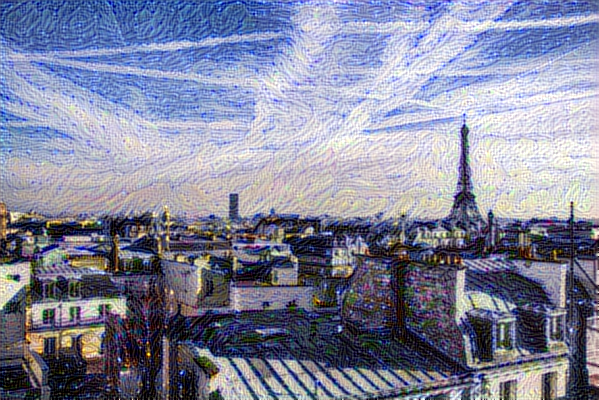

In [14]:
#Después de 4000 iteraciones, obtiene el siguiente resultado:
display(Image(result_prefix + "_de_iteración_400.png"))